In [2]:
import torch
import numpy as np
import os
import random
import pandas as pd
from astropy.io import fits
from case_studies.galaxy_clustering.utils import diagnostics
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from astropy.table import Table

In [13]:
image_g = fits.getdata("/data/scratch/des/new_psf_data/galsim_des_000_g.fits")
image_r = fits.getdata("/data/scratch/des/new_psf_data/galsim_des_000_r.fits")
image_i = fits.getdata("/data/scratch/des/new_psf_data/galsim_des_000_i.fits")

In [14]:
image_g.shape

(2560, 2560)

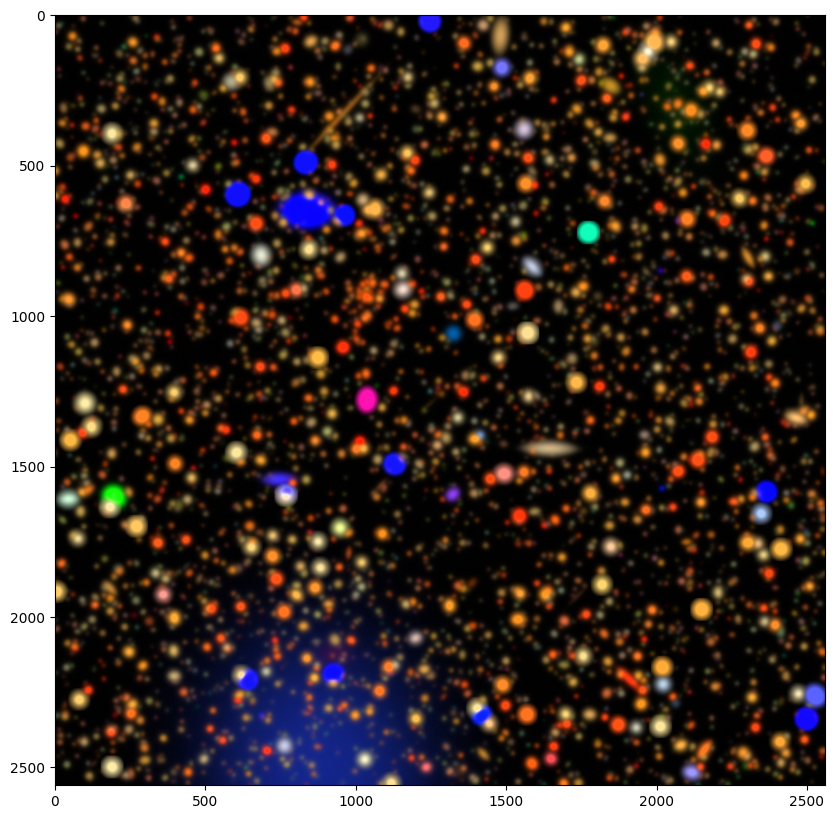

In [15]:
rgb_default = make_lupton_rgb(image_i, image_r, image_g)
plt.figure(figsize=(10,10))
plt.imshow(rgb_default)

In [16]:
image_g = fits.getdata("/data/scratch/des/piff_test_data/images/galsim_des_000_g.fits")
image_r = fits.getdata("/data/scratch/des/piff_test_data/images/galsim_des_000_r.fits")
image_i = fits.getdata("/data/scratch/des/piff_test_data/images/galsim_des_000_i.fits")

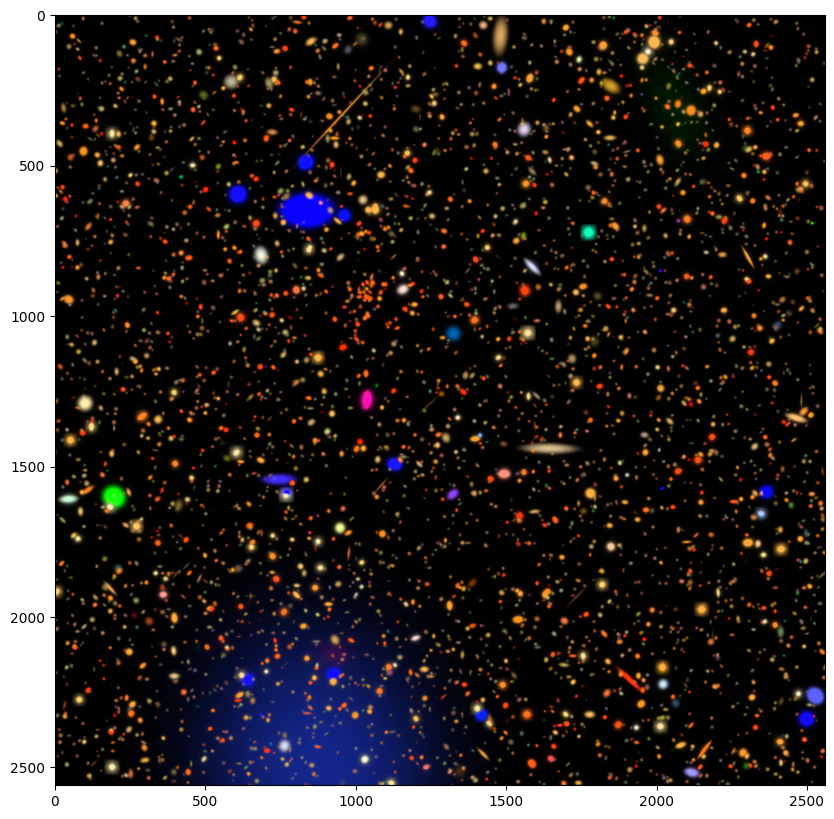

In [17]:
rgb_default = make_lupton_rgb(image_i, image_r, image_g)
plt.figure(figsize=(10,10))
plt.imshow(rgb_default)

In [2]:
import os

In [11]:
DES_PATH = "/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles"
DES_TILES = os.listdir("/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles")
for DES_TILE_PATH in DES_TILES:
    files = os.listdir(f"{DES_PATH}/{DES_TILE_PATH}")
    print(files)
    break

['DES0409-2458_r4939p01_z_nobkg.cat', 'DES0409-2458_r4939p01_r_nobkg.psf', 'DES0409-2458_r4939p01_i_nobkg.psf', 'DES0409-2458_r4939p01_z_nobkg.fits', 'DES0409-2458_r4939p01_g_nobkg.fits', 'DES0409-2458_r4939p01_i_nobkg.fits', 'DES0409-2458_r4939p01_r_nobkg.fits', 'DES0409-2458_r4939p01_z_nobkg.psf', 'DES0409-2458_r4939p01_g_nobkg.psf', 'DES0409-2458_r4939p01_r_nobkg.cat', 'DES0409-2458_r4939p01_i_nobkg.cat', 'DES0409-2458_r4939p01_g_nobkg.cat']


In [12]:
NEW_DES_PATH =  "/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles_reformatted"
os.mkdir(NEW_DES_PATH)

In [13]:
NEW_DES_R_PATH =  "/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles_reformatted/rband"
NEW_DES_G_PATH =  "/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles_reformatted/gband"
NEW_DES_I_PATH =  "/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles_reformatted/iband"
NEW_DES_Z_PATH =  "/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles_reformatted/zband"

os.mkdir(NEW_DES_G_PATH)
os.mkdir(NEW_DES_R_PATH)
os.mkdir(NEW_DES_I_PATH)
os.mkdir(NEW_DES_Z_PATH)

In [35]:
import shutil
for i, DES_TILE_PATH in enumerate(DES_TILES):
    files = os.listdir(f"{DES_PATH}/{DES_TILE_PATH}")
    rpsf = [file for file in files if file.endswith("r_nobkg.psf")][0]
    source_file = f"{DES_PATH}/{DES_TILE_PATH}/{rpsf}"
    dest_file = f"{NEW_DES_R_PATH}/galsim_des_{i:03d}_r.psf"
    shutil.copy(source_file, dest_file)
    print(f"Directory {i} done!")

Directory 0 done!
Directory 1 done!
Directory 2 done!
Directory 3 done!
Directory 4 done!
Directory 5 done!
Directory 6 done!
Directory 7 done!
Directory 8 done!
Directory 9 done!
Directory 10 done!
Directory 11 done!
Directory 12 done!
Directory 13 done!
Directory 14 done!
Directory 15 done!
Directory 16 done!
Directory 17 done!
Directory 18 done!
Directory 19 done!
Directory 20 done!
Directory 21 done!
Directory 22 done!
Directory 23 done!
Directory 24 done!
Directory 25 done!
Directory 26 done!
Directory 27 done!
Directory 28 done!
Directory 29 done!
Directory 30 done!
Directory 31 done!
Directory 32 done!
Directory 33 done!
Directory 34 done!
Directory 35 done!
Directory 36 done!
Directory 37 done!
Directory 38 done!
Directory 39 done!
Directory 40 done!
Directory 41 done!
Directory 42 done!
Directory 43 done!
Directory 44 done!
Directory 45 done!
Directory 46 done!
Directory 47 done!
Directory 48 done!
Directory 49 done!
Directory 50 done!
Directory 51 done!
Directory 52 done!
Dir

In [36]:
import shutil
for i, DES_TILE_PATH in enumerate(DES_TILES):
    files = os.listdir(f"{DES_PATH}/{DES_TILE_PATH}")
    gpsf = [file for file in files if file.endswith("g_nobkg.psf")][0]
    source_file = f"{DES_PATH}/{DES_TILE_PATH}/{gpsf}"
    dest_file = f"{NEW_DES_G_PATH}/galsim_des_{i:03d}_g.psf"
    shutil.copy(source_file, dest_file)
    print(f"Directory {i} done!")

Directory 0 done!
Directory 1 done!
Directory 2 done!
Directory 3 done!
Directory 4 done!
Directory 5 done!
Directory 6 done!
Directory 7 done!
Directory 8 done!
Directory 9 done!
Directory 10 done!
Directory 11 done!
Directory 12 done!
Directory 13 done!
Directory 14 done!
Directory 15 done!
Directory 16 done!
Directory 17 done!
Directory 18 done!
Directory 19 done!
Directory 20 done!
Directory 21 done!
Directory 22 done!
Directory 23 done!
Directory 24 done!
Directory 25 done!
Directory 26 done!
Directory 27 done!
Directory 28 done!
Directory 29 done!
Directory 30 done!
Directory 31 done!
Directory 32 done!
Directory 33 done!
Directory 34 done!
Directory 35 done!
Directory 36 done!
Directory 37 done!
Directory 38 done!
Directory 39 done!
Directory 40 done!
Directory 41 done!
Directory 42 done!
Directory 43 done!
Directory 44 done!
Directory 45 done!
Directory 46 done!
Directory 47 done!
Directory 48 done!
Directory 49 done!
Directory 50 done!
Directory 51 done!
Directory 52 done!
Dir

In [37]:
import shutil
for i, DES_TILE_PATH in enumerate(DES_TILES):
    files = os.listdir(f"{DES_PATH}/{DES_TILE_PATH}")
    ipsf = [file for file in files if file.endswith("i_nobkg.psf")][0]
    source_file = f"{DES_PATH}/{DES_TILE_PATH}/{ipsf}"
    dest_file = f"{NEW_DES_I_PATH}/galsim_des_{i:03d}_i.psf"
    shutil.copy(source_file, dest_file)
    print(f"Directory {i} done!")

Directory 0 done!
Directory 1 done!
Directory 2 done!
Directory 3 done!
Directory 4 done!
Directory 5 done!
Directory 6 done!
Directory 7 done!
Directory 8 done!
Directory 9 done!
Directory 10 done!
Directory 11 done!
Directory 12 done!
Directory 13 done!
Directory 14 done!
Directory 15 done!
Directory 16 done!
Directory 17 done!
Directory 18 done!
Directory 19 done!
Directory 20 done!
Directory 21 done!
Directory 22 done!
Directory 23 done!
Directory 24 done!
Directory 25 done!
Directory 26 done!
Directory 27 done!
Directory 28 done!
Directory 29 done!
Directory 30 done!
Directory 31 done!
Directory 32 done!
Directory 33 done!
Directory 34 done!
Directory 35 done!
Directory 36 done!
Directory 37 done!
Directory 38 done!
Directory 39 done!
Directory 40 done!
Directory 41 done!
Directory 42 done!
Directory 43 done!
Directory 44 done!
Directory 45 done!
Directory 46 done!
Directory 47 done!
Directory 48 done!
Directory 49 done!
Directory 50 done!
Directory 51 done!
Directory 52 done!
Dir

In [38]:
import shutil
for i, DES_TILE_PATH in enumerate(DES_TILES):
    files = os.listdir(f"{DES_PATH}/{DES_TILE_PATH}")
    zpsf = [file for file in files if file.endswith("z_nobkg.psf")][0]
    source_file = f"{DES_PATH}/{DES_TILE_PATH}/{zpsf}"
    dest_file = f"{NEW_DES_Z_PATH}/galsim_des_{i:03d}_z.psf"
    shutil.copy(source_file, dest_file)
    print(f"Directory {i} done!")

Directory 0 done!
Directory 1 done!
Directory 2 done!
Directory 3 done!
Directory 4 done!
Directory 5 done!
Directory 6 done!
Directory 7 done!
Directory 8 done!
Directory 9 done!
Directory 10 done!
Directory 11 done!
Directory 12 done!
Directory 13 done!
Directory 14 done!
Directory 15 done!
Directory 16 done!
Directory 17 done!
Directory 18 done!
Directory 19 done!
Directory 20 done!
Directory 21 done!
Directory 22 done!
Directory 23 done!
Directory 24 done!
Directory 25 done!
Directory 26 done!
Directory 27 done!
Directory 28 done!
Directory 29 done!
Directory 30 done!
Directory 31 done!
Directory 32 done!
Directory 33 done!
Directory 34 done!
Directory 35 done!
Directory 36 done!
Directory 37 done!
Directory 38 done!
Directory 39 done!
Directory 40 done!
Directory 41 done!
Directory 42 done!
Directory 43 done!
Directory 44 done!
Directory 45 done!
Directory 46 done!
Directory 47 done!
Directory 48 done!
Directory 49 done!
Directory 50 done!
Directory 51 done!
Directory 52 done!
Dir